In [ ]:
!pip install transformers[torch]==4.19.2 -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from time import time
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
plt.rcParams["figure.dpi"] = 200

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ",device)
seed = 42
np.random.seed(seed)

Device available:  cuda


In [ ]:
# Input

# Trained Model
distilbert_model = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/model/distilbert_unprocessed_v1.pth'

# Input Data
data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_distilbert_input_unprocessed.pkl'

# DistilBERT Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [ ]:
# Function to generate batches and reshape
def batching(np_array, max_idx, batch_size):
    np_array = np_array[:max_idx]
    np_array = np_array.reshape(-1, batch_size)
    batched_list = np_array.tolist()
    return batched_list

In [ ]:
# Temperature Scaling
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

In [ ]:
# Function for predicting y
def bert_pred(model_path, X, y, th=0.5, temp=None):
    loaded_model = torch.load(model_path)
    predictions, targets = [], []
    pred_prob = []
    loaded_model.eval()
    with torch.no_grad():
        for text, labels in tqdm(zip(X, y), total=len(X)):
            #try:
            model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
            output = loaded_model(**model_inputs)
            logits = output[0]
            if temp is not None:
                logits = T_scaling(logits, {'temperature':temp})
            probs = torch.sigmoid(logits)
            pred_prob.extend(probs[:,1].tolist())
            if th==0.5:
                # prediction is the argmax of the logits
                predictions.extend(logits.argmax(dim=1).tolist())
            else:
                predictions.extend(((probs[:,1]>=th)*1).tolist())
            targets.extend(labels)
            #except:
            #    print("Unable to process: ", text)
            #    continue
    return targets, pred_prob, predictions

In [ ]:
# Read data
df = pd.read_pickle(data_path)
df['filing_dt'] = pd.to_datetime(df['filing_dt'])


# Divide data into train, test and validation
df_train = df[(df['filing_dt']>=pd.to_datetime('2012-01-01')) & (df['filing_dt']<=pd.to_datetime('2017-12-31'))]
df_val = df[(df['filing_dt']>=pd.to_datetime('2018-01-01')) & (df['filing_dt']<=pd.to_datetime('2018-12-31'))]
df_test = df[(df['filing_dt']>=pd.to_datetime('2019-01-01')) & (df['filing_dt']<=pd.to_datetime('2019-12-31'))]
print("Train data shape: ", df_train.shape)
print("Validation data shape: ", df_val.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (1001779, 22)
Validation data shape:  (234752, 22)
Test data shape:  (264827, 22)


In [ ]:
# X_test
X_test = np.array(df_test['bert_input_unprocessed'])
# y_test
y_test = np.array(df_test['distinct_ind'])


batch_size = 16
# Batching
test_max_idx = batch_size * (len(X_test)//batch_size)
X_test = batching(X_test, test_max_idx, batch_size=16)
y_test = batching(y_test, test_max_idx, batch_size=16)

In [ ]:
labels, pred_prob, predictions = bert_pred(distilbert_model, X_test, y_test)

100%|██████████| 16551/16551 [27:26<00:00, 10.05it/s]


In [ ]:
# Function to convert pred probabilities into logits
def prob_to_logits(pred_prob):
    probabilities = np.array(pred_prob, dtype=np.float64)
    logits_array = np.log(probabilities/(1-probabilities))
    return logits_array

In [ ]:
# Function to calibrate probabilities using temperature scaling
def calibrate_classifier(pred_prob, labels):
    temperature = nn.Parameter(torch.ones(1).cuda())
    args = {'temperature': temperature}
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')
    logits_array = prob_to_logits(pred_prob)
    labels_array = np.array(labels, dtype=np.float64)
    temps = []
    losses = []

    # Create tensors
    logits_list = torch.from_numpy(logits_array).to(device)
    labels_list = torch.from_numpy(labels_array).to(device)

    # Optimize for temperature
    def _eval():
        loss = criterion(T_scaling(logits_list, args), labels_list)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        #print("Loss-List: ", loss)
        #print("Temperature-List: ", temps)
        return loss

    optimizer.step(_eval)
    print('Final T_scaling factor: {:.2f}'.format(temperature.item()))
    return temperature.item()

In [ ]:
temperature = calibrate_classifier(pred_prob, labels)


Final T_scaling factor: 0.75


In [ ]:
temp_labels, temp_pred_probs, temp_predictions = bert_pred(distilbert_model, X_test, y_test, temp=temperature)

100%|██████████| 16551/16551 [27:29<00:00, 10.04it/s]


In [ ]:
len(temp_pred_probs)

264816

In [ ]:
len(temp_labels)

264816

In [ ]:
len(X_test)

16551

In [ ]:
16551*16

264816

In [ ]:
X_test[-1][-1]

'[CLS] MIDNIGHT ONYX HYBRID [SEP] Dietary supplements containing cannabidiol (CBD) derived from industrial hemp [SEP] no translation required [SEP] mark present in Wordnet [SEP] mark length is 3 [SEP] NICE category is 5 [SEP] Pharmaceuticals, medical and veterinary preparations; Sanitary preparations for medical purposes; Dietetic food and substances adapted for medical or veterinary use, food for babies; Dietary supplements for human beings and animals; Plasters, materials for dressings; Material for stopping teeth, dental wax; Disinfectants; Preparations for destroying vermin; Fungicides, herbicides [SEP] no Pseudo mark'

In [ ]:
df_test.iloc[-12]

serial_no                                                                   88743088
filing_dt                                                        2019-12-31 00:00:00
mark_processed                                                  MIDNIGHT ONYX HYBRID
mark_unprocessed                                                MIDNIGHT ONYX HYBRID
distinct_ind                                                                       0
intl_class_cd                                                                      5
mark_len                                                                           3
wn_ind                                                                             1
mark_final                                                      MIDNIGHT ONYX HYBRID
translated_ind                                                                   0.0
mark_translated                                              no translation required
nice_description_preprocessed      pharmaceuticals medical and ve

In [ ]:
temp_labels[-1]

0

In [ ]:
df_test_final = df_test.iloc[:len(temp_labels)]
df_test_final['labels'] = temp_labels
df_test_final['pred_probs'] = temp_pred_probs
df_test_final['predicted_labels'] = temp_predictions
assert((df_test_final['labels'] == df_test_final['distinct_ind']).sum() == len(df_test_final))

<ipython-input-33-774cca15b2c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_final['labels'] = temp_labels
<ipython-input-33-774cca15b2c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_final['pred_probs'] = temp_pred_probs
<ipython-input-33-774cca15b2c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [ ]:
df_test_final.head()

,serial_no,filing_dt,mark_processed,mark_unprocessed,distinct_ind,intl_class_cd,mark_len,wn_ind,mark_final,translated_ind,...,statement_processed,statement_unprocessed,wordnet_text,mark_length_text,nice_cat_text,bert_input_processed,bert_input_unprocessed,labels,pred_probs,predicted_labels
1236531,88246509,2019-01-01,AFRICAN AMERICAN MYTHOLOGY,AFRICAN AMERICAN MYTHOLOGY,0,45,3,1,AFRICAN AMERICAN MYTHOLOGY,0.0,...,providing information in the field of african ...,Providing information in the field of African ...,mark present in Wordnet,mark length is 3,NICE category is 45,[CLS] AFRICAN AMERICAN MYTHOLOGY [SEP] providi...,[CLS] AFRICAN AMERICAN MYTHOLOGY [SEP] Providi...,0,0.254144,0
1236532,88246510,2019-01-01,WORLD ANTIBULLYING CARD,WORLD ANTI-BULLYING CARD,1,16,3,1,WORLD ANTIBULLYING CARD,0.0,...,antibullying card note cards namely cards used...,"""ANTI-BULLYING CARD"" Note cards, namely, cards...",mark present in Wordnet,mark length is 3,NICE category is 16,[CLS] WORLD ANTIBULLYING CARD [SEP] antibullyi...,"[CLS] WORLD ANTI-BULLYING CARD [SEP] ""ANTI-BUL...",1,0.200188,0
1236533,88246511,2019-01-01,BYAKKO,BYAKKO,1,35,1,0,white tiger,1.0,...,business management consulting and advisory se...,Business management consulting and advisory se...,mark absent in Wordnet,mark length is 1,NICE category is 35,[CLS] BYAKKO [SEP] business management consult...,[CLS] BYAKKO [SEP] Business management consult...,1,0.693940,1
1236534,88246512,2019-01-01,QUALITY,QUALITY,0,40,1,1,QUALITY,0.0,...,color is not claimed as a feature of the mark ...,Color is not claimed as a feature of the mark....,mark present in Wordnet,mark length is 1,NICE category is 40,[CLS] QUALITY [SEP] color is not claimed as a ...,[CLS] QUALITY [SEP] Color is not claimed as a ...,0,0.629738,1
1236535,88246514,2019-01-01,PILOT CREW CREATIVE,PILOT CREW CREATIVE,1,16,3,1,PILOT CREW CREATIVE,0.0,...,art prints paintings,Art prints; Paintings,mark present in Wordnet,mark length is 3,NICE category is 16,[CLS] PILOT CREW CREATIVE [SEP] art prints pai...,[CLS] PILOT CREW CREATIVE [SEP] Art prints; Pa...,1,0.752618,1


In [ ]:
df_test_final.to_csv('/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_distilbert_predictions_with_probs.csv',index=False)

In [ ]:
df_test_final = pd.read_csv('/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/df_distilbert_predictions_with_probs.csv')
df_test_final

,serial_no,filing_dt,mark_processed,mark_unprocessed,distinct_ind,intl_class_cd,mark_len,wn_ind,mark_final,translated_ind,...,statement_processed,statement_unprocessed,wordnet_text,mark_length_text,nice_cat_text,bert_input_processed,bert_input_unprocessed,labels,pred_probs,predicted_labels
0,88246509,2019-01-01,AFRICAN AMERICAN MYTHOLOGY,AFRICAN AMERICAN MYTHOLOGY,0,45,3,1,AFRICAN AMERICAN MYTHOLOGY,0.0,...,providing information in the field of african ...,Providing information in the field of African ...,mark present in Wordnet,mark length is 3,NICE category is 45,[CLS] AFRICAN AMERICAN MYTHOLOGY [SEP] providi...,[CLS] AFRICAN AMERICAN MYTHOLOGY [SEP] Providi...,0,0.254144,0
1,88246510,2019-01-01,WORLD ANTIBULLYING CARD,WORLD ANTI-BULLYING CARD,1,16,3,1,WORLD ANTIBULLYING CARD,0.0,...,antibullying card note cards namely cards used...,"""ANTI-BULLYING CARD"" Note cards, namely, cards...",mark present in Wordnet,mark length is 3,NICE category is 16,[CLS] WORLD ANTIBULLYING CARD [SEP] antibullyi...,"[CLS] WORLD ANTI-BULLYING CARD [SEP] ""ANTI-BUL...",1,0.200188,0
2,88246511,2019-01-01,BYAKKO,BYAKKO,1,35,1,0,white tiger,1.0,...,business management consulting and advisory se...,Business management consulting and advisory se...,mark absent in Wordnet,mark length is 1,NICE category is 35,[CLS] BYAKKO [SEP] business management consult...,[CLS] BYAKKO [SEP] Business management consult...,1,0.693940,1
3,88246512,2019-01-01,QUALITY,QUALITY,0,40,1,1,QUALITY,0.0,...,color is not claimed as a feature of the mark ...,Color is not claimed as a feature of the mark....,mark present in Wordnet,mark length is 1,NICE category is 40,[CLS] QUALITY [SEP] color is not claimed as a ...,[CLS] QUALITY [SEP] Color is not claimed as a ...,0,0.629738,1
4,88246514,2019-01-01,PILOT CREW CREATIVE,PILOT CREW CREATIVE,1,16,3,1,PILOT CREW CREATIVE,0.0,...,art prints paintings,Art prints; Paintings,mark present in Wordnet,mark length is 3,NICE category is 16,[CLS] PILOT CREW CREATIVE [SEP] art prints pai...,[CLS] PILOT CREW CREATIVE [SEP] Art prints; Pa...,1,0.752618,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264811,88743119,2019-12-31,ABBOTT STATION,ABBOTT STATION,0,41,2,1,ABBOTT STATION,0.0,...,providing a recreation center and facilities,Providing a recreation center and facilities,mark present in Wordnet,mark length is 2,NICE category is 41,[CLS] ABBOTT STATION [SEP] providing a recreat...,[CLS] ABBOTT STATION [SEP] Providing a recreat...,0,0.674850,1
264812,88743120,2019-12-31,BLOCKPRAXIS,BLOCKPRAXIS,1,42,1,0,BLOCKPRAXIS,0.0,...,electronic document and email timestamping ser...,Electronic document and e-mail time-stamping s...,mark absent in Wordnet,mark length is 1,NICE category is 42,[CLS] BLOCKPRAXIS [SEP] electronic document an...,[CLS] BLOCKPRAXIS [SEP] Electronic document an...,1,0.814290,1
264813,88743124,2019-12-31,HIDEOUT,HIDEOUT,1,33,1,1,HIDEOUT,0.0,...,spirits as beverages distilled spirits vodka,Spirits as beverages; distilled spirits; vodka,mark present in Wordnet,mark length is 1,NICE category is 33,[CLS] HIDEOUT [SEP] spirits as beverages disti...,[CLS] HIDEOUT [SEP] Spirits as beverages; dist...,1,0.880316,1
264814,88743131,2019-12-31,DESI PURE,DESI PURE,0,35,2,1,DESI PURE,0.0,...,wholesale food distributorship services,Wholesale food distributorship services,mark present in Wordnet,mark length is 2,NICE category is 35,[CLS] DESI PURE [SEP] wholesale food distribut...,[CLS] DESI PURE [SEP] Wholesale food distribut...,0,0.414450,0


In [ ]:
df_test_correct = df_test_final[df_test_final['labels']==df_test_final['predicted_labels']].copy()
print(df_test_correct.shape)

(226884, 25)


In [ ]:
df_test_correct = df_test_correct[['serial_no','mark_unprocessed','statement_unprocessed','distinct_ind','pred_probs']].copy()
df_test_correct

,serial_no,mark_unprocessed,statement_unprocessed,distinct_ind,pred_probs
0,88246509,AFRICAN AMERICAN MYTHOLOGY,Providing information in the field of African ...,0,0.254144
2,88246511,BYAKKO,Business management consulting and advisory se...,1,0.693940
4,88246514,PILOT CREW CREATIVE,Art prints; Paintings,1,0.752618
5,88246522,FABFIT,Yoga blocks; Yoga boards; Yoga cushions; Yoga ...,1,0.899378
6,88246517,SL SKYLAB TECHNOLOGIES,The color(s) Black and Red is/are claimed as a...,1,0.943555
...,...,...,...,...,...
264809,79278564,VELFASHION,Perfumery and cosmetics,1,0.896086
264810,88743115,WATERDOGS,"Entertainment services, namely, organizing and...",1,0.563695
264812,88743120,BLOCKPRAXIS,Electronic document and e-mail time-stamping s...,1,0.814290
264813,88743124,HIDEOUT,Spirits as beverages; distilled spirits; vodka,1,0.880316


In [ ]:
df_test_correct = df_test_correct.sort_values(by=['pred_probs'], ascending=False)

In [ ]:
df_test_correct

,serial_no,mark_unprocessed,statement_unprocessed,distinct_ind,pred_probs
10778,88267144,IXUPTA,Pharmaceutical preparations for the prevention...,1,0.993659
43260,88329928,YUDEMSA,Pharmaceutical preparations for the prevention...,1,0.992983
67779,88375813,VOVANSPRI,Human pharmaceutical preparations for the prev...,1,0.990843
10952,88267415,AFFAVAGAA,Pharmaceutical preparations for the prevention...,1,0.990618
85760,88410396,BECMANTA,Human pharmaceutical preparations for the prev...,1,0.987630
...,...,...,...,...,...
40634,88323961,CHARLESTON ELECTRICAL CONTRACTORS ASSOCIATION,"""ASSOCIATION"" Association services, namely, pr...",0,0.006753
111876,88461942,NATIONAL POTATO COUNCIL,"""COUNCIL"" Association services, namely, promot...",0,0.006262
247210,88711637,USA BACKGROUND CHECKS,"""BACKGROUND CHECKS"" Background screenings and ...",0,0.006251
69113,88380036,U.S. SCOTCH DOUBLES CHAMPIONSHIP,"""SCOTCH DOUBLES CHAMPIONSHIP"" Entertainment se...",0,0.005399


In [ ]:
df_test_correct['statement_unprocessed'].loc[10778]

'Pharmaceutical preparations for the prevention and treatment of cardiovascular diseases and diseases of the central nervous system; pharmaceutical preparations for the treatment of cancer, thrombosis, and respiratory diseases; pharmaceutical preparations for the treatment of lysosomal storage diseases; pharmaceutical preparations for the prevention and treatment of infectious diseases, namely, viral and bacterial infections'

In [ ]:
df_test_correct['statement_unprocessed'].loc[43260]

'Pharmaceutical preparations for the prevention and treatment of cardiovascular diseases and diseases of the central nervous system; pharmaceutical preparations for the treatment of cancer, thrombosis, and respiratory diseases; pharmaceutical preparations for the treatment of rare diseases; pharmaceutical preparations for the prevention and treatment of infectious diseases, namely, viral and bacterial infections'

In [ ]:
df_test_correct['statement_unprocessed'].loc[10952]

'Pharmaceutical preparations for the prevention and treatment of cardiovascular diseases and diseases of the central nervous system; pharmaceutical preparations for the treatment of cancer, thrombosis, and respiratory diseases; pharmaceutical preparations for the treatment of lysosomal storage diseases; pharmaceutical preparations for the prevention and treatment of infectious diseases, namely, viral and bacterial infections'

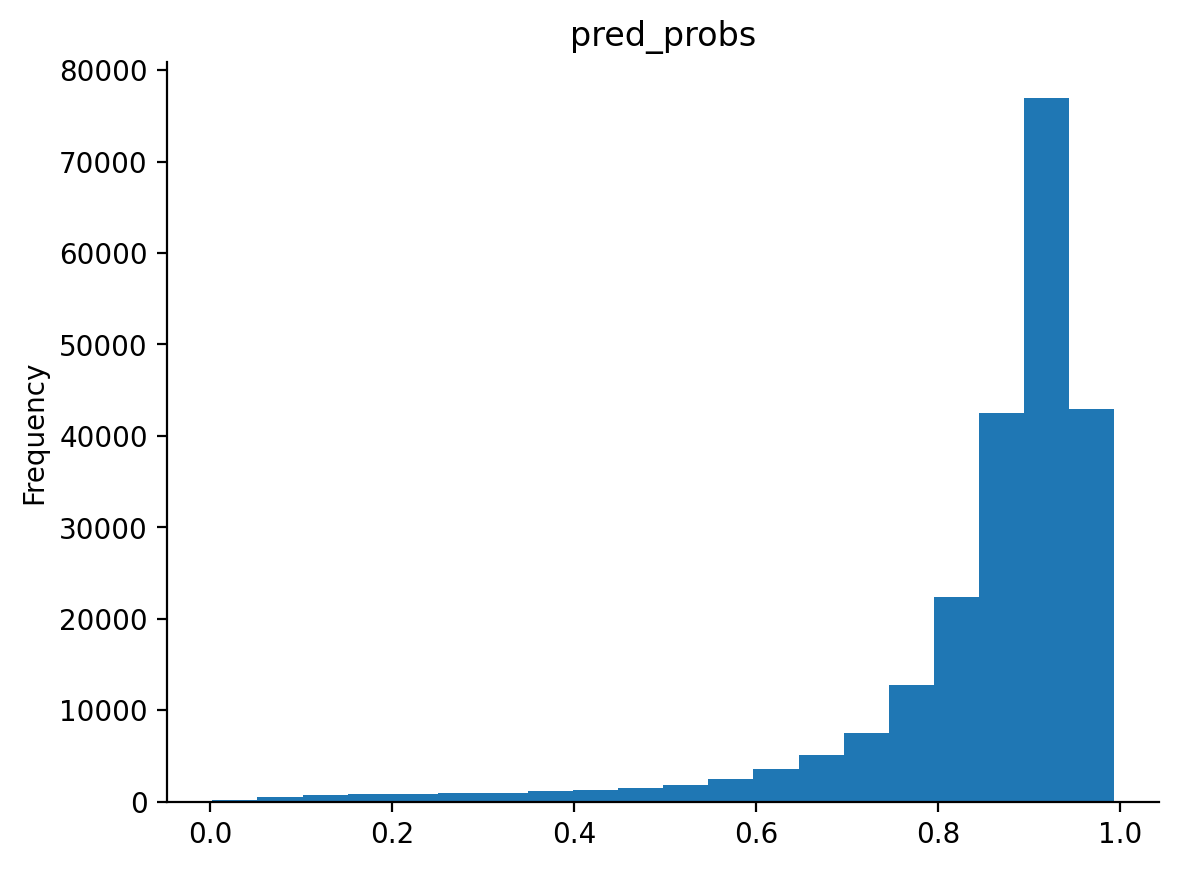

In [ ]:
from matplotlib import pyplot as plt
df_test_correct['pred_probs'].plot(kind='hist', bins=20, title='pred_probs')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_test_correct['intervals'] = pd.cut(df_test_correct['pred_probs'],
                                      bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05,
                                              0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85,
                                              0.9, 0.95, 0.96, 0.97, 0.98, 1])

In [ ]:
df_test_correct

,serial_no,mark_unprocessed,statement_unprocessed,distinct_ind,pred_probs,intervals
10778,88267144,IXUPTA,Pharmaceutical preparations for the prevention...,1,0.993659,"(0.98, 1.0]"
43260,88329928,YUDEMSA,Pharmaceutical preparations for the prevention...,1,0.992983,"(0.98, 1.0]"
67779,88375813,VOVANSPRI,Human pharmaceutical preparations for the prev...,1,0.990843,"(0.98, 1.0]"
10952,88267415,AFFAVAGAA,Pharmaceutical preparations for the prevention...,1,0.990618,"(0.98, 1.0]"
85760,88410396,BECMANTA,Human pharmaceutical preparations for the prev...,1,0.987630,"(0.98, 1.0]"
...,...,...,...,...,...,...
40634,88323961,CHARLESTON ELECTRICAL CONTRACTORS ASSOCIATION,"""ASSOCIATION"" Association services, namely, pr...",0,0.006753,"(0.0, 0.01]"
111876,88461942,NATIONAL POTATO COUNCIL,"""COUNCIL"" Association services, namely, promot...",0,0.006262,"(0.0, 0.01]"
247210,88711637,USA BACKGROUND CHECKS,"""BACKGROUND CHECKS"" Background screenings and ...",0,0.006251,"(0.0, 0.01]"
69113,88380036,U.S. SCOTCH DOUBLES CHAMPIONSHIP,"""SCOTCH DOUBLES CHAMPIONSHIP"" Entertainment se...",0,0.005399,"(0.0, 0.01]"


In [ ]:
df_test_correct[:30]

,serial_no,mark_unprocessed,statement_unprocessed,distinct_ind,pred_probs,intervals
10778,88267144,IXUPTA,Pharmaceutical preparations for the prevention...,1,0.993659,"(0.98, 1.0]"
43260,88329928,YUDEMSA,Pharmaceutical preparations for the prevention...,1,0.992983,"(0.98, 1.0]"
67779,88375813,VOVANSPRI,Human pharmaceutical preparations for the prev...,1,0.990843,"(0.98, 1.0]"
10952,88267415,AFFAVAGAA,Pharmaceutical preparations for the prevention...,1,0.990618,"(0.98, 1.0]"
85760,88410396,BECMANTA,Human pharmaceutical preparations for the prev...,1,0.987630,"(0.98, 1.0]"
82799,88405340,YUGETA,"Batteries, electric; Battery chargers; Cables,...",1,0.987212,"(0.98, 1.0]"
83925,88406752,YEMPRIS,Human pharmaceutical preparations for the prev...,1,0.987118,"(0.98, 1.0]"
230243,88680774,APRETUDE,Pharmaceutical preparations and substances for...,1,0.986495,"(0.98, 1.0]"
10785,88267154,ZYMPOEM,Pharmaceutical preparations for the prevention...,1,0.986277,"(0.98, 1.0]"
74685,88389799,VABREPTA,Pharmaceutical preparations and substances for...,1,0.986258,"(0.98, 1.0]"


In [ ]:
df_test_correct.groupby(by=['intervals']).count()

,serial_no,mark_unprocessed,statement_unprocessed,distinct_ind,pred_probs
intervals,,,,,
"(0.0, 0.01]",8,8,8,8,8
"(0.01, 0.02]",25,25,25,25,25
"(0.02, 0.03]",43,43,43,43,43
"(0.03, 0.04]",61,61,61,61,61
"(0.04, 0.05]",56,56,56,56,56
"(0.05, 0.1]",554,554,554,554,554
"(0.1, 0.15]",696,696,696,696,696
"(0.15, 0.2]",798,798,798,798,798
"(0.2, 0.25]",865,865,865,865,865


In [ ]:
df_sample_5_each = df_test_correct.groupby("intervals").sample(n=5, random_state=seed, replace=False)


In [ ]:
df_test_correct['larger_intervals'] = pd.cut(df_test_correct['pred_probs'],
                                      bins = [0, 0.05,
                                              0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85,
                                              0.9, 0.95, 0.96, 0.97, 0.98, 1])

In [ ]:
df_sample_100_each = df_test_correct.groupby("larger_intervals").sample(n=100, random_state=seed, replace=False)

In [ ]:
df_sample_5_each_save = df_sample_5_each[['serial_no','mark_unprocessed','distinct_ind','pred_probs','intervals']].copy()
df_sample_100_each_save = df_sample_100_each[['serial_no','mark_unprocessed','distinct_ind','pred_probs','larger_intervals']].copy()
print(df_sample_5_each_save.shape)
print(df_sample_100_each_save.shape)

(135, 5)
(2300, 5)


In [ ]:
df_sample_5_each['pred_probs'] = df_sample_5_each['pred_probs'].apply(lambda x: np.round(x, 4))
df_sample_100_each['pred_probs'] = df_sample_100_each['pred_probs'].apply(lambda x: np.round(x, 4))

In [ ]:
df_sample_100_each

,serial_no,mark_unprocessed,statement_unprocessed,distinct_ind,pred_probs,intervals,larger_intervals
254598,88726396,CERTIFIED RETIREMENT PLAN PROFESSIONAL,"Educational training services, namely, conduct...",0,0.0421,"(0.04, 0.05]","(0.0, 0.05]"
168612,88565561,USA SURF TEAM,"""SURF TEAM"" Providing financial support for at...",0,0.0254,"(0.02, 0.03]","(0.0, 0.05]"
249111,88716597,GEOCHEMISTRY INTERNATIONAL,"Downloadable electronic publications, namely, ...",0,0.0368,"(0.03, 0.04]","(0.0, 0.05]"
184459,88594529,USA WORKERS INJURY NETWORK,"""WORKERS INJURY NETWORK"" Provision of a health...",0,0.0234,"(0.02, 0.03]","(0.0, 0.05]"
214991,88653678,FLORIDA'S HEMP BANK,"""BANK"" Banking services; Financial services, n...",0,0.0311,"(0.03, 0.04]","(0.0, 0.05]"
...,...,...,...,...,...,...,...
152780,88539581,ANYU,Beard clippers; Bits for hand drills; Depilato...,1,0.9809,"(0.98, 1.0]","(0.98, 1.0]"
10069,88266441,SUNNYPIG,Baby multiple activity toys; Bath toys; Buildi...,1,0.9819,"(0.98, 1.0]","(0.98, 1.0]"
10973,88267405,ADSELZYME,Pharmaceutical preparations for the prevention...,1,0.9808,"(0.98, 1.0]","(0.98, 1.0]"
230516,88681515,YJBYYX,Artificial fishing bait; Bite indicators; Fish...,1,0.9811,"(0.98, 1.0]","(0.98, 1.0]"


In [ ]:
df_sample_5_each.to_csv('/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/samples_with_probs_135.csv',index=False)
df_sample_100_each.to_csv('/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/samples_with_probs_2300.csv',index=False)


In [ ]:
df_sample_5_each.shape

(135, 6)

In [ ]:
df_sample_100_each.shape

(2300, 7)